In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import performance_metric_score

In [3]:
dataset = pd.read_csv('titanic.csv')
print(dataset.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
X = dataset[['Age', 'Fare', 'Sex'] + [col for col in dataset.columns if 'Embarked' in col]] #features
y = dataset['Pclass'] #target variable

#One-hot encode the target variable (Pclass)
y_one_hot = pd.get_dummies(y, prefix='Pclass')

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

#checking the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

#converting true/false into 1 or 0 using astype()
X_train[['Embarked_Q', 'Embarked_S']] = X_train[['Embarked_Q', 'Embarked_S']].astype(int)
X_test[['Embarked_Q', 'Embarked_S']] = X_test[['Embarked_Q', 'Embarked_S']].astype(int)

#after updates
print(X_train[['Embarked_Q', 'Embarked_S']].head())

X_train shape: (712, 5)
X_test shape: (179, 5)
y_train shape: (712, 3)
y_test shape: (179, 3)
     Embarked_Q  Embarked_S
331           0           1
733           0           1
382           0           1
704           0           1
813           0           1


In [6]:
scaler = StandardScaler()

X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

# Check if everything looks fine now
print(X_train.head())

# Debug: Check for NaNs in the scaled features
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())

          Age      Fare  Sex  Embarked_Q  Embarked_S
331  1.253641 -0.078684    0           0           1
733 -0.477284 -0.377145    0           0           1
382  0.215086 -0.474867    0           0           1
704 -0.246494 -0.476230    0           0           1
813 -1.785093 -0.025249    1           0           1
NaNs in X_train: Age           0
Fare          0
Sex           0
Embarked_Q    0
Embarked_S    0
dtype: int64
NaNs in X_test: Age           0
Fare          0
Sex           0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [7]:
def softmax(scores):
    """
    Compute the softmax probabilities from raw model scores (logits).
    
    Args:
    - scores (numpy.ndarray): Raw output scores (shape: (num_samples, num_classes))

    Returns:
    - probs (numpy.ndarray): The computed softmax probabilities (shape: (num_samples, num_classes))
    """
    # Stabilize exponentiation by subtracting the maximum score in each row
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [8]:
def test_softmax():
    scores = np.array([[1.2, 0.9, 0.8], [1.1, 0.4, 1.2]])
    probs = softmax(scores)
    assert np.allclose(np.sum(probs, axis=1), 1), "Test failed: Softmax probabilities don't sum to 1"
    print(softmax(scores))
    print("test case passed!")
test_softmax()

[[0.41474187 0.30724834 0.27800979]
 [0.38435576 0.19086542 0.42477881]]
test case passed!


In [9]:
def cross_entropy_cost(y_true, y_pred):
    """
    Computes the cross-entropy cost between the true labels (y_true) and the predicted probabilities (y_pred).
    
    Args:
    - y_true (numpy.ndarray): One-hot encoded true labels (shape: (num_samples, num_classes))
    - y_pred (numpy.ndarray): Predicted probabilities (shape: (num_samples, num_classes))
    
    Returns:
    - cost (float): The computed cross-entropy cost
    """
    y_pred = np.clip(y_pred, 1e-15 , 1 - 1e-15 )  # Avoid numerical issues with log(0)
    cost = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return cost

In [10]:
# Customized for personal use
# Customized for your assignments
def test_cross_entropy_cost():
    y_true = np.array([[1, 0, 0], [0, 1, 0]])
    y_pred = np.array([[0.7, 0.2, 0.1], [0.2, 0.7, 0.1]])
    cost = cross_entropy_cost(y_true, y_pred)
    assert cost >= 0, "Test failed: Loss should be non-negative"
    print(cross_entropy_cost(y_true, y_pred))
    print("test case passed!")
test_cross_entropy_cost()

0.35667494393873245
test case passed!


In [11]:
def compute_gradients(X, Y, probs):
    """
    Compute the gradients of the cost function with respect to parameters and biases.
    
    Args:
    - X (numpy.ndarray): Feature matrix (shape: (num_samples, num_features))
    - Y (numpy.ndarray): One-hot encoded true labels (shape: (num_samples, num_classes))
    - probs (numpy.ndarray): Predicted probabilities from softmax (shape: (num_samples, num_classes))
    
    Returns:
    - grad_W (numpy.ndarray): Gradient of cost with respect to parameters (shape: (num_features, num_classes))
    - grad_b (numpy.ndarray): Gradient of cost with respect to biases (shape: (1, num_classes))
    """
    num_samples = X.shape[0]
    grad_W = np.dot(X.T, (probs - Y)) / num_samples
    grad_b = np.sum(probs - Y, axis=0, keepdims=True) / num_samples
    return grad_W, grad_b

In [12]:
# Customized for personal use
# Customized for your assignments
def test_compute_gradients():
    X = np.random.randn(5, 3)  # Sample dataset
    Y = np.random.randint(0, 2, (5, 3)) 
    probs = np.random.rand(5, 3)  
    grad_W, grad_b = compute_gradients(X, Y, probs)
    assert grad_W.shape == (X.shape[1], Y.shape[1]), "Test failed: Gradient W has incorrect shape"
    assert grad_b.shape == (1, Y.shape[1]), "Test failed: Gradient b has incorrect shape"
    print("Gradient W:", grad_W.shape)
    print("Gradient b:", grad_b.shape)
    print("test case passed!")
test_compute_gradients()

Gradient W: (3, 3)
Gradient b: (1, 3)
test case passed!


In [14]:
def model(X, Y, alpha=0.01, epochs=1000):
    """
    Perform softmax regression on the datasetset.
    
    Args:
    - X (numpy.ndarray): Feature matrix (shape: (num_samples, num_features))
    - Y (numpy.ndarray): One-hot encoded true labels (shape: (num_samples, num_classes))
    - alpha (float): Learning rate for gradient descent
    - epochs (int): Number of iterations to train the model
    
    Returns:
    - W (numpy.ndarray): Learned parameters (shape: (num_features, num_classes))
    - b (numpy.ndarray): Learned biases (shape: (1, num_classes))
    - cost_history (list): List of cost values recorded during training
    """
    
    W = np.random.randn(X.shape[1], Y.shape[1])
    b = np.zeros((1, Y.shape[1]))

    cost_history = []  

    for epoch in range(epochs):
        
        scores = np.dot(X, W) + b
        probs = softmax(scores) 

        cost = cross_entropy_cost(Y, probs)
        cost_history.append(cost) 

        # Compute gradients
        grad_W, grad_b = compute_gradients(X, Y, probs)

        # Update parameters and biases using gradient descent
        W -= alpha * grad_W
        b -= alpha * grad_b

        # Optionally, print cost every 100 iterations for debugging
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {cost}')

    return W, b, cost_history

In [15]:
def test_softmax():
    scores = np.array([[1.2, 0.9, 0.8], [1.1, 0.4, 1.2]])
    probs = softmax(scores)
    assert np.allclose(np.sum(probs, axis=1), 1), "Test failed: Softmax probabilities don't sum to 1"
    print("test_softmax passed!")
test_softmax()   

test_softmax passed!


Epoch 0, Loss: 2.7763977481646376
Epoch 100, Loss: 1.995123531963728
Epoch 200, Loss: 1.4162715859145592
Epoch 300, Loss: 1.048927131617425
Epoch 400, Loss: 0.8647261574744836
Epoch 500, Loss: 0.7843488290930964
Epoch 600, Loss: 0.7482815449190467
Epoch 700, Loss: 0.7296788588043437
Epoch 800, Loss: 0.718340033922037
Epoch 900, Loss: 0.7104032761759566


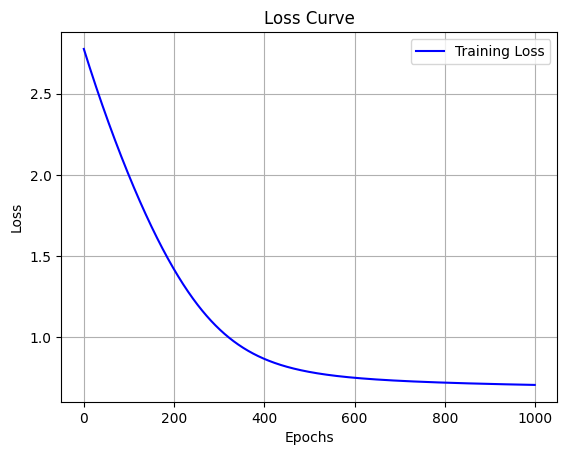

In [16]:
X_train_np = X_train.to_numpy()  # or X_train.values
y_train_np = y_train.to_numpy()  # Ensure one-hot encoded labels

# Perform softmax regression
W, b, cost_history = model(X_train_np, y_train_np, alpha=0.01, epochs=1000)

# Plot the cost curve
def plot_cost_curve(cost_history):
    """
    Plots the cost curve using the recorded cost history.

    Args:
    - cost_history (list): List of cost values over epochs.
    """
    plt.plot(cost_history, color='blue', label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function
plot_cost_curve(cost_history)


In [20]:
def predict(X, W, b):
    """
    Predict the class labels for new dataset points.
    
    Args:
    - X (numpy.ndarray): Feature matrix for new dataset (shape: (num_samples, num_features))
    - W (numpy.ndarray): Learned parameters (shape: (num_features, num_classes))
    - b (numpy.ndarray): Learned biases (shape: (1, num_classes))
    
    Returns:
    - predictions (numpy.ndarray): Predicted class labels (shape: (num_samples,))
    """
    scores = np.dot(X, W) + b
    probs = softmax(scores)  
    return np.argmax(probs, axis=1) 

In [21]:
def test_predict():
    X_train = np.random.randn(100, 3)
    W = np.random.randn(3, 3)
    b = np.random.randn(1, 3)
    predictions = predict(X_train, W, b)
    assert predictions.shape[0] == X_train.shape[0], "Test failed: Prediction output size mismatch"
    print("test_predict passed!")
test_predict()

test_predict passed!


In [19]:
train_predictions = predict(X_train, W, b)
test_predictions = predict(X_test, W, b)

train_performance_metric = performance_metric_score(np.argmax(y_train, axis=1), train_predictions)
test_performance_metric = performance_metric_score(np.argmax(y_test, axis=1), test_predictions)

print(f"Training Accuracy: {train_performance_metric * 100:.2f}%")
print(f"Testing Accuracy: {test_performance_metric * 100:.2f}%")

Training Accuracy: 71.35%
Testing Accuracy: 70.95%
